# 教程：使用 GIT 进行图像/视频描述生成和图像/视频问答（QA）

本笔记本演示了如何使用MindSpore的 GIT 模型来对图像或视频进行描述生成，以及在图像或视频上进行问答。

### GIT 快速介绍

GIT（GenerativeImage2Text 的缩写）是一个标准的 Transformer 解码器，它的条件输入同时包含 CLIP 图像 patch token 和文本 token。模型的目标是：在给定图像 token 和已有文本 token 的情况下，预测下一个文本 token。

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/git_architecture.jpg" alt="图示" width="800"/>

该模型在大量的（图像，文本）对上进行了预训练。需要注意的是，作者并未开源大型的 GIT 和 GIT-2 模型，只发布了较小的变体 GIT-base 和 GIT-large 以及多个微调后的检查点。尽管如此，这些模型仍然非常强大，很可能是目前开源领域在相应任务上表现最好的模型之一！

## 环境搭建

**环境配置：**

1. MindSpore 2.3.0
2. Mindnlp 0.3.1
3. Python 3.9

**使用华为云 ModelArts 作为AI平台**

在环境搭建部分，使用了AI gallery社区中相关mindnlp项目搭建mindnlp环境的代码。

### 环境配置

配置python3.9环境

In [ ]:
%%capture captured_output
!/home/ma-user/anaconda3/bin/conda create -n python-3.9.0 python=3.9.0 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.9.0/bin/pip install ipykernel

In [ ]:
import json
import os

data = {
   "display_name": "python-3.9.0",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.9.0/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.9.0/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

*注：以上代码执行完成后，需点击左上角或右上角将kernel更换为python-3.10.0*

2. 安装mindspore2.3.0，安装指南详见：[MindSpore安装](https://www.mindspore.cn/install/)

3. 安装MindNLP及相关依赖，MindNLP官方仓详见：[MindNLP](https://github.com/mindspore-lab/mindnlp)

In [ ]:
!pip install mindspore==2.3.0
!pip install mindnlp==0.3.1
!pip install -q decord
!pip install ipywidgets

In [1]:
!pip show mindspore
!pip show mindnlp

Name: mindspore
Version: 2.3.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, scipy
Required-by: mindnlp
Name: mindnlp
Version: 0.3.1
Summary: An open source natural language processing research tool box. Git version: [sha1]:978ab37, [branch]: (HEAD -> master, tag: v0.3.1, ms/master)
Home-page: https://github.com/mindlab-ai/mindnlp/tree/master/
Author: MindSpore Team
Author-email: 
License: Apache 2.0
Location: /home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages
Requires: addict, datasets, evaluate, jieba, mindspore, ml-dtypes, pyctcdecode, pytest, regex, requests, safetensors, sentencepiece, tokenizers,

## 加载图像

接下来，我们可以加载任何想要的图像。

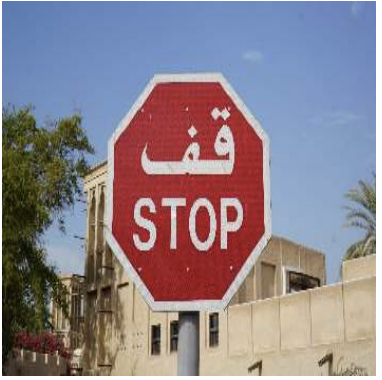

In [7]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"       #huggingface镜像    
from huggingface_hub import hf_hub_download
from PIL import Image
filepath = hf_hub_download(repo_id="nielsr/textcaps-sample", filename="stop_sign.png", repo_type="dataset", endpoint='https://hf-mirror.com')
image = Image.open(filepath).convert("RGB")
image

## 为模型准备图像

可以使用 `GitProcessor` 来准备图像。该处理器同时包含图像处理器（用于图像模态）和分词器（用于文本模态）。向它传入图像时，它会自动使用图像处理器。

In [9]:
from mindnlp.transformers import AutoProcessor

# the Auto API automatically loads a GitProcessor for us
processor = AutoProcessor.from_pretrained("microsoft/git-base-textcaps")

pixel_values = processor(images=image, return_tensors="ms").pixel_values
pixel_values.shape

(1, 3, 224, 224)

## 定义模型

接下来，我们从 [Hugging Face Hub](https://huggingface.co/microsoft/git-base-textcaps) 加载一个 GIT 模型。这里我加载的是在 [TextCaps](https://paperswithcode.com/dataset/textcaps) 数据集（一个大型图像描述数据集）上微调过的 GIT-base 模型。

In [ ]:
from mindnlp.transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textcaps")

In [10]:
from mindnlp.transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textcaps", from_pt=True)

GitForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`.`PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[MS_ALLOC_CONF]Runtime config:  enable_vmm:True  vmm_align_size:2MB


## 生成描述

只需调用 `generate` 方法并传入像素值，就可以生成图像描述。注意这里默认使用的是贪心解码，但还有更多解码策略，详见[这篇博客](https://huggingface.co/blog/how-to-generate)。

In [11]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=20)
print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a stop sign with arabic writing on it']


## 一次性演示所有任务

既然我们已经展示了图像描述生成，下面用简短的代码片段演示所有任务：

- 图像描述生成  
- 视觉问答（VQA）  
- 视频描述生成  
- 视频视觉问答（VQA）  

### 图像描述生成

我们加载另一张图像来进行描述生成。

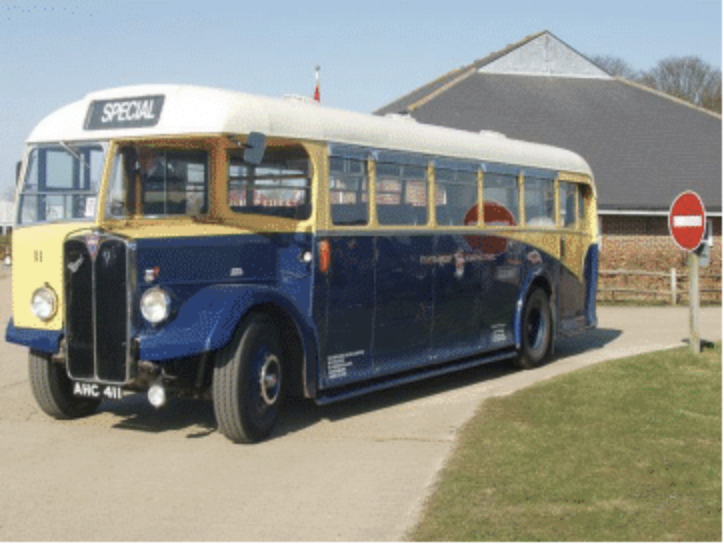

In [18]:
from huggingface_hub import hf_hub_download
from PIL import Image

def prepare_image():
  filepath = hf_hub_download(repo_id="nielsr/textvqa-sample", filename="bus.png", repo_type="dataset", endpoint='https://hf-mirror.com')
  image = Image.open(filepath).convert("RGB")

  return image

image = prepare_image()
image

下面我们再从 🤗 Hub 加载一个在 COCO 数据集上微调的不同 GIT 模型。

In [19]:
from mindnlp.transformers import AutoProcessor, AutoModelForCausalLM

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

inputs = processor(images=prepare_image(), return_tensors="ms")
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a bus that is parked in a driveway.']


### 视觉问答（VQA）

GIT 也在视觉问答数据集（如 TextVQA）上进行了微调。让我们针对这张公交车图像提一个问题。

In [20]:
import mindspore

processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa")

pixel_values = processor(images=prepare_image(), return_tensors="ms").pixel_values

question = "what does the front of the bus say at the top?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = mindspore.Tensor(input_ids, dtype=mindspore.int64).expand_dims(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)

print("Generated answer:", processor.batch_decode(generated_ids[:, input_ids.shape[1]:], skip_special_tokens=True))

Generated answer: ['special']


### 视频描述生成

作者甚至在视频描述生成和视频问答数据集上微调了 GIT。

要让 GIT 处理视频，思路很简单：将多帧 CLIP 嵌入与时间嵌入一起作为条件，传入 Transformer 解码器（详见本笔记本顶部的架构图）。

让我们安装 `decord` 并加载一个在视频描述生成数据集上微调过的 GIT 模型：

In [38]:
# —————— 脚本开头 Monkey‐patch ——————  
from mindnlp.core.nn.modules.container import ParameterList  
# 备份原 extend 方法  
_orig_extend = ParameterList.extend  
# 重写，把非 list 的 iterable（比如 generator）先转 list  
def _patched_extend(self, parameters):  
    if not isinstance(parameters, list) and parameters is not None:  
        parameters = list(parameters)  
    return _orig_extend(self, parameters)  
# 应用补丁  
ParameterList.extend = _patched_extend  

# —————— 后面正常 load 模型 ——————  
import os  
from mindnlp.transformers import AutoProcessor, AutoModelForCausalLM, AutoConfig  

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"  
processor = AutoProcessor.from_pretrained("microsoft/git-base-vatex")  

# 你可以根据需要调整帧数，如果只做单图像，设 None；如果要多帧视频，就设成 checkpoint 的帧数（默认 6）  
config = AutoConfig.from_pretrained("microsoft/git-base-vatex")  
config.num_image_with_embedding = 6  

model = AutoModelForCausalLM.from_pretrained(  
    "microsoft/git-base-vatex",  
    config=config  
)  

让我们加载一个视频

In [24]:
!python -c "from huggingface_hub import hf_hub_download; file_path = hf_hub_download(repo_id='nielsr/video-demo', filename='eating_spaghetti.mp4', repo_type='dataset', endpoint='https://hf-mirror.com', local_dir='.')"

In [26]:
from IPython.display import HTML

# 使用本地文件路径
video_path = "eating_spaghetti.mp4"

# 显示视频
video_html = f"""
<video width="500" controls>
  <source src="{video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
"""
HTML(video_html)

我们需要从视频中采样几帧，然后将它们提供给 GIT。作者选择每个视频使用 6 帧，因此我们需要从视频中采样 6 帧并传入模型。

In [40]:
num_frames = model.config.num_image_with_embedding
print(num_frames)

6


要解码视频，我们使用 [decord](https://github.com/dmlc/decord) 库。采样可以通过 NumPy 完成，我们在下面将其封装成一个函数：

In [43]:
import numpy as np
from decord import VideoReader, cpu

def sample_frames(file_path, num_frames):
    # set seed for reproducability
    np.random.seed(45)

    def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
        converted_len = int(clip_len * frame_sample_rate)
        end_idx = np.random.randint(converted_len, seg_len)
        start_idx = end_idx - converted_len
        indices = np.linspace(start_idx, end_idx, num=clip_len)
        indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
        return indices

    # video clip consists of 300 frames (10 seconds at 30 FPS)
    videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

    # sample 6 frames
    videoreader.seek(0)
    indices = sample_frame_indices(clip_len=num_frames, frame_sample_rate=4, seg_len=len(videoreader))
    frames = videoreader.get_batch(indices).asnumpy()

    return list(frames)

frames = sample_frames(file_path, num_frames)

当然，模型的性能会很大程度上依赖于它所看到的帧，让我们先看看采样到了哪些帧：

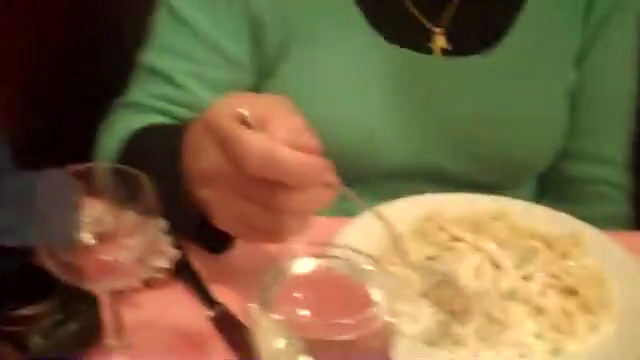

In [44]:
# visualize first sampled frame
Image.fromarray(frames[0])

好了，现在让我们用这些帧进行一次前向推理！

In [45]:
inputs = processor(images=frames, return_tensors="ms")
generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a woman is sitting at a table and she is talking about the food she is holding.']


### 视频问答（Video question answering）

我们也可以使用 GIT 来回答与视频相关的问题。思路与视频描述生成完全相同，唯一不同的是除了传入帧的 token，还要额外传入“问题 token”来条件化模型。

下面我们从 Hugging Face Hub 加载一个在视频 QA 数据集上微调的 GIT 模型，这里以在 [MSRVTT-QA](https://paperswithcode.com/sota/visual-question-answering-on-msrvtt-qa-1) 数据集上微调的版本为例。

In [46]:
# GIT fine-tuned on a video QA dataset
processor = AutoProcessor.from_pretrained("microsoft/git-base-msrvtt-qa")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-msrvtt-qa")

100%|██████████| 453/453 [00:00<00:00, 1.39MB/s]
226kB [00:01, 180kB/s]  
695kB [00:01, 547kB/s] 
100%|██████████| 125/125 [00:00<00:00, 331kB/s]
2.75kB [00:00, 3.23MB/s]                 
100%|██████████| 674M/674M [07:21<00:00, 1.60MB/s]   
100%|██████████| 141/141 [00:00<00:00, 215kB/s]


In [48]:
# prepare video
inputs = processor(images=frames, return_tensors="ms")
# prepare question
question = "what is the woman eating?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = mindspore.Tensor(input_ids, dtype=mindspore.int64).expand_dims(0)
print("Generating...")
generated_ids = model.generate(pixel_values=inputs.pixel_values, input_ids=input_ids, max_length=50)
print("Generated:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generating...
Generated: ['what is the woman eating? meal']
